In [1]:
import pandas as pd
import pandas_profiling

In [2]:
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler, RobustScaler,OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
#Marking from which dataset the data comes and concating them
train['train'] =1
test['train']=0
test['default'] = 2 #creating a column to concate
banking = pd.concat([train,test], ignore_index = True)

In [5]:
banking.profile_report()

In [6]:
#For making future work easier create lists with types of data in columns
target = 'default'
time_cols = ['app_date']
cat_cols = ['education',  'home_address', 'work_address', 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
num_cols = ['age','decline_app_cnt','region_rating','score_bki','bki_request_cnt','income']
#client id is not needed
banking.drop('client_id', axis = 1, inplace =True)

# Time

In [7]:
#need to reform time columns first
banking['app_date'] = pd.to_datetime(banking['app_date'], format='%d%b%Y')
#Need to get all the data possible - will decide what to do later
banking['day'] = banking['app_date'].dt.day
banking['month'] = banking['app_date'].dt.month
banking['year'] = banking['app_date'].dt.year

In [8]:
time_cols_2  = ['day','month','year']
banking.loc[:,time_cols_2].describe()

day          month      year
count  110148.000000  110148.000000  110148.0
mean       15.959100       2.535107    2014.0
std         8.598467       1.087680       0.0
min         1.000000       1.000000    2014.0
25%         9.000000       2.000000    2014.0
50%        16.000000       3.000000    2014.0
75%        23.000000       3.000000    2014.0
max        31.000000       4.000000    2014.0

In [9]:
#The only year present is 2014, so the year is not needed
banking.drop('year', axis = 1, inplace =True)

In [10]:
#As the year is only 2014, it is logical to count days from 1st january 2014
st_jan_2014 = pd.to_datetime('1/1/2014')
banking['delta_t'] = (banking['app_date']-st_jan_2014 ).dt.days

In [11]:
#As I've agglomerated the time data into delta, we dont need other time columns
banking.drop(['day','app_date','month'],axis = 1, inplace = True)

In [12]:
banking

education sex  age car car_type  decline_app_cnt  good_work  score_bki  \
0            SCH   M   62   Y        Y                0          0  -2.008753   
1            SCH   F   59   N        N                0          0  -1.532276   
2            SCH   M   25   Y        N                2          0  -1.408142   
3            SCH   F   53   N        N                0          0  -2.057471   
4            GRD   M   48   N        N                0          1  -1.244723   
...          ...  ..  ...  ..      ...              ...        ...        ...   
110143       SCH   F   37   N        N                1          0  -1.744976   
110144       GRD   F   64   Y        Y                0          0  -2.293781   
110145       GRD   M   31   N        N                2          0  -0.940752   
110146       UGR   F   27   N        N                1          0  -1.242392   
110147       SCH   M   38   N        N                0          0  -1.507549   

        bki_request_cnt  region_rating  home_address  work_address  income  \
0                     1             50             1             2   18000   
1                     3             50             2             3   19000   
2                     1             80             1             2   30000   
3                     2             50             2             3   10000   
4                     1             60             2             3   30000   
...                 ...            ...           ...           ...     ...   
110143                3             50             2             3   15000   
110144                3             60             1             2  200000   
110145                1             50             1             2   60000   
110146                2             80             2             3   30000   
110147                2             50             1             2   15000   

        sna  first_time foreign_passport  default  train  delta_t  
0         4           1                N        0      1       31  
1         4           1                N        0      1       70  
2         1           4                Y        0      1       31  
3         1           3                N        0      1       22  
4         1           4                Y        0      1      107  
...     ...         ...              ...      ...    ...      ...  
110143    4           1                N        2      0       89  
110144    1           4                N        2      0      114  
110145    4           2                N        2      0       88  
110146    1           1                N        2      0        6  
110147    4           2                N        2      0       75  

[110148 rows x 19 columns]

# Education

In [13]:
#Education is the only column, which has NONEs
banking.isna().sum()

education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
train                 0
delta_t               0
dtype: int64

In [14]:
#Filling them with the most often value
banking['education'].fillna('SCH', inplace = True)

# Categorial

In [15]:
#Need to change str to int - Use OneHotEncoder
X_cat_train = OneHotEncoder(sparse = False).fit_transform(banking[banking.train == 1][cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(banking[banking.train == 0][cat_cols].values)
#will use it later

# Binaries

In [16]:
#Making bainary columns usable for logistic regression-use LabelEncoder
lable_enc = LabelEncoder()
for col in bin_cols:
    banking[col] = lable_enc.fit_transform(banking[col])

# Distribution

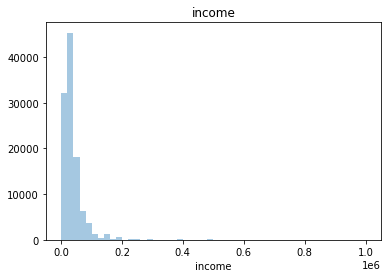

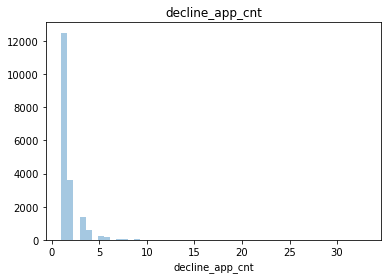

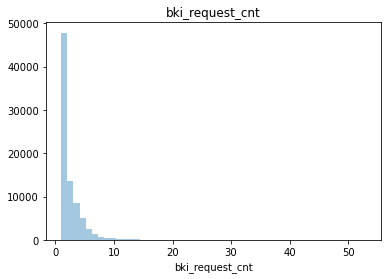

In [17]:
for i in ['income','decline_app_cnt','bki_request_cnt']:
    plt.figure()
    sns.distplot(banking[i][banking[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

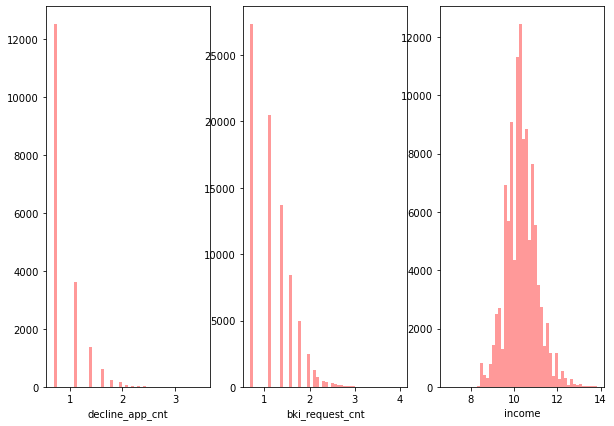

In [18]:
#Can be seen that values are strongly inclined to the left - trying log[log+1 to avoid mathematical error]
fig, axes = plt.subplots(1, 3, figsize=(10,7))
for i,col in enumerate(['decline_app_cnt', 'bki_request_cnt', 'income']):
    banking[col] = np.log(banking[col] + 1)
    sns.distplot(banking[col][banking[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False,color="r")

age
decline_app_cnt


C:\Users\Dmitry Trushin\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


region_rating
score_bki
bki_request_cnt
income


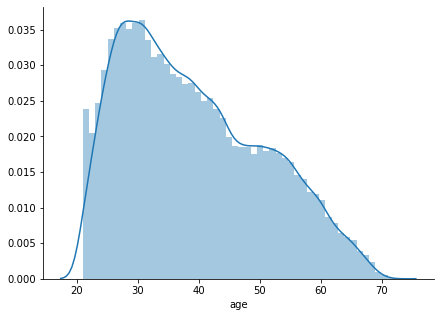

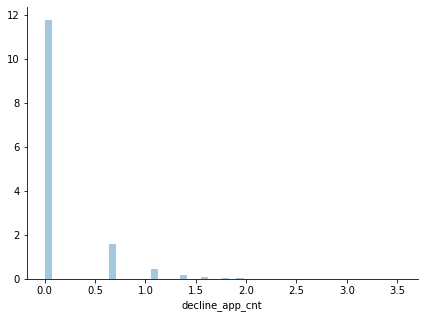

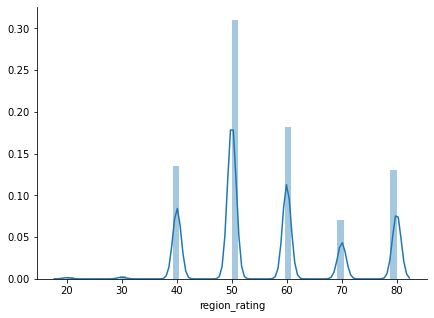

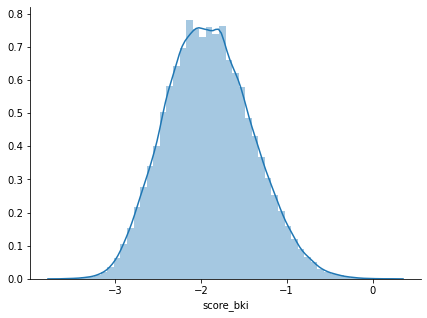

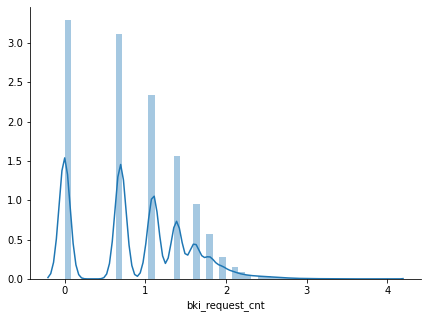

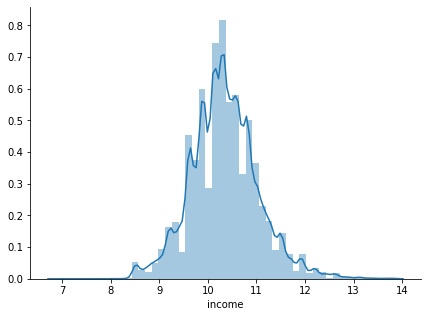

In [19]:
#Lets analyze numerical columns more thoroughly
for col in num_cols:
    print(col)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.despine(f)
    sns.distplot(
    banking[col])

age


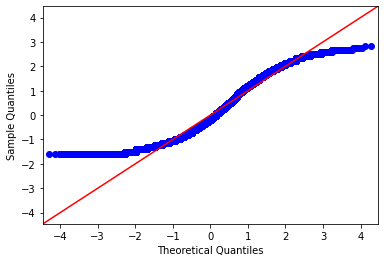

decline_app_cnt


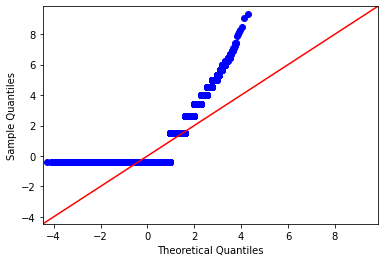

region_rating


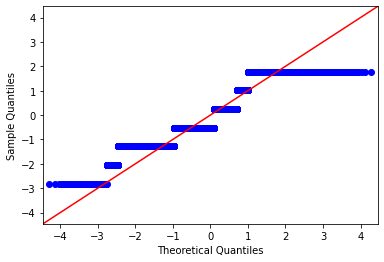

score_bki


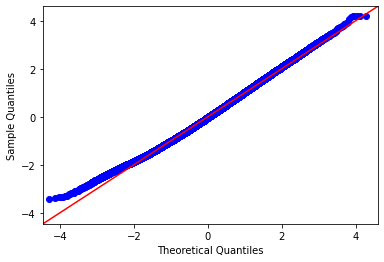

bki_request_cnt


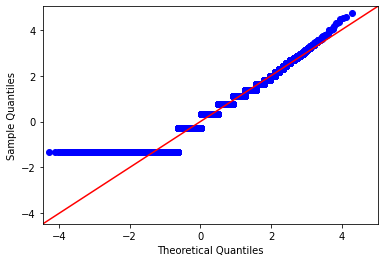

income


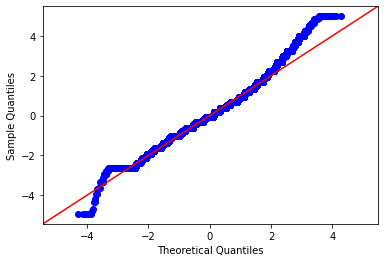

In [20]:
#use qq to determine whether the distribution is eneven
import statsmodels.api as sm
import pylab
for col in num_cols:
    print(col)
    sm.qqplot(banking[col], line='45',fit = True)
    pylab.show()

age


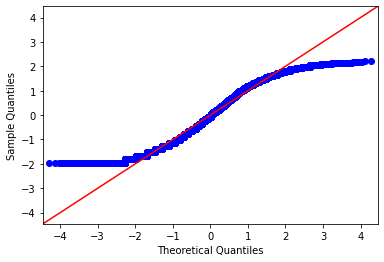

decline_app_cnt


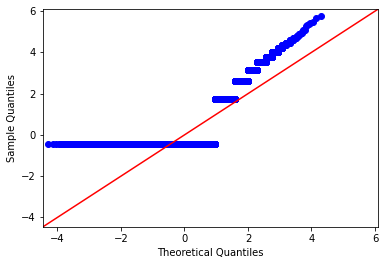

bki_request_cnt


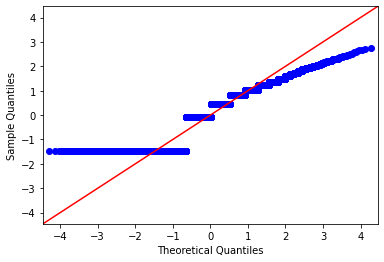

income


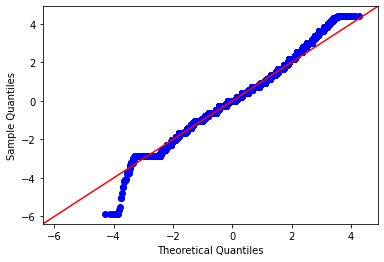

In [21]:
quest_cols = ['age','decline_app_cnt','bki_request_cnt','income']
for col in quest_cols:
    print(col)
    sm.qqplot((banking[col]+1).transform(np.log), line='45',fit = True)
    pylab.show()

age
decline_app_cnt
region_rating


C:\Users\Dmitry Trushin\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


score_bki
bki_request_cnt
income


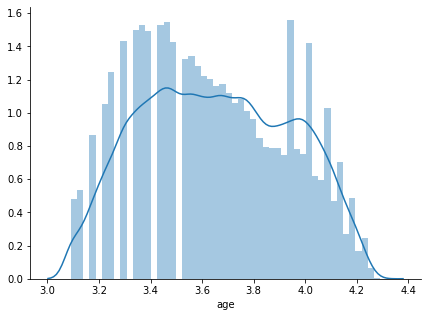

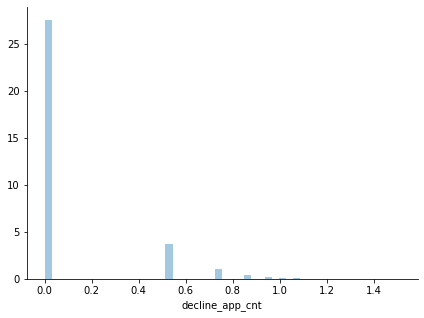

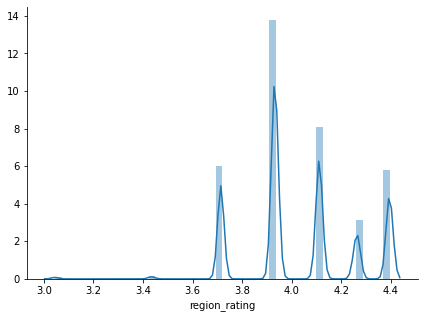

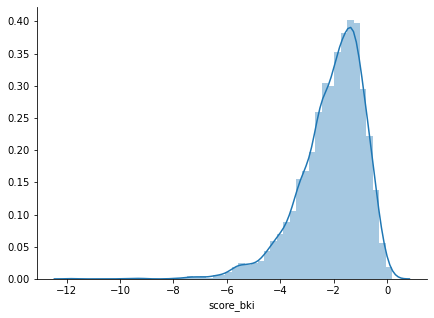

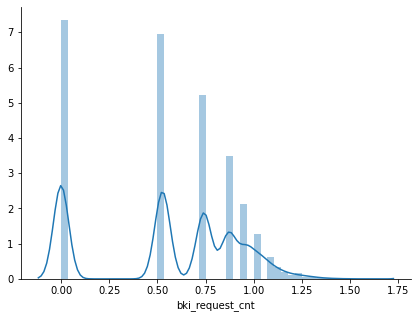

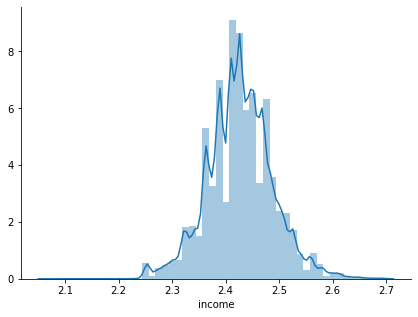

In [22]:
for col in num_cols:
    print(col)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.despine(f)
    sns.distplot(
    (banking[col]+1).transform(np.log))

In [23]:
#per graphs, we should apply log to age, decline_app_cnt,income
log_cols = ['age','decline_app_cnt','income']
for col in log_cols:
    banking[col] = (banking[col]+1).transform(np.log)

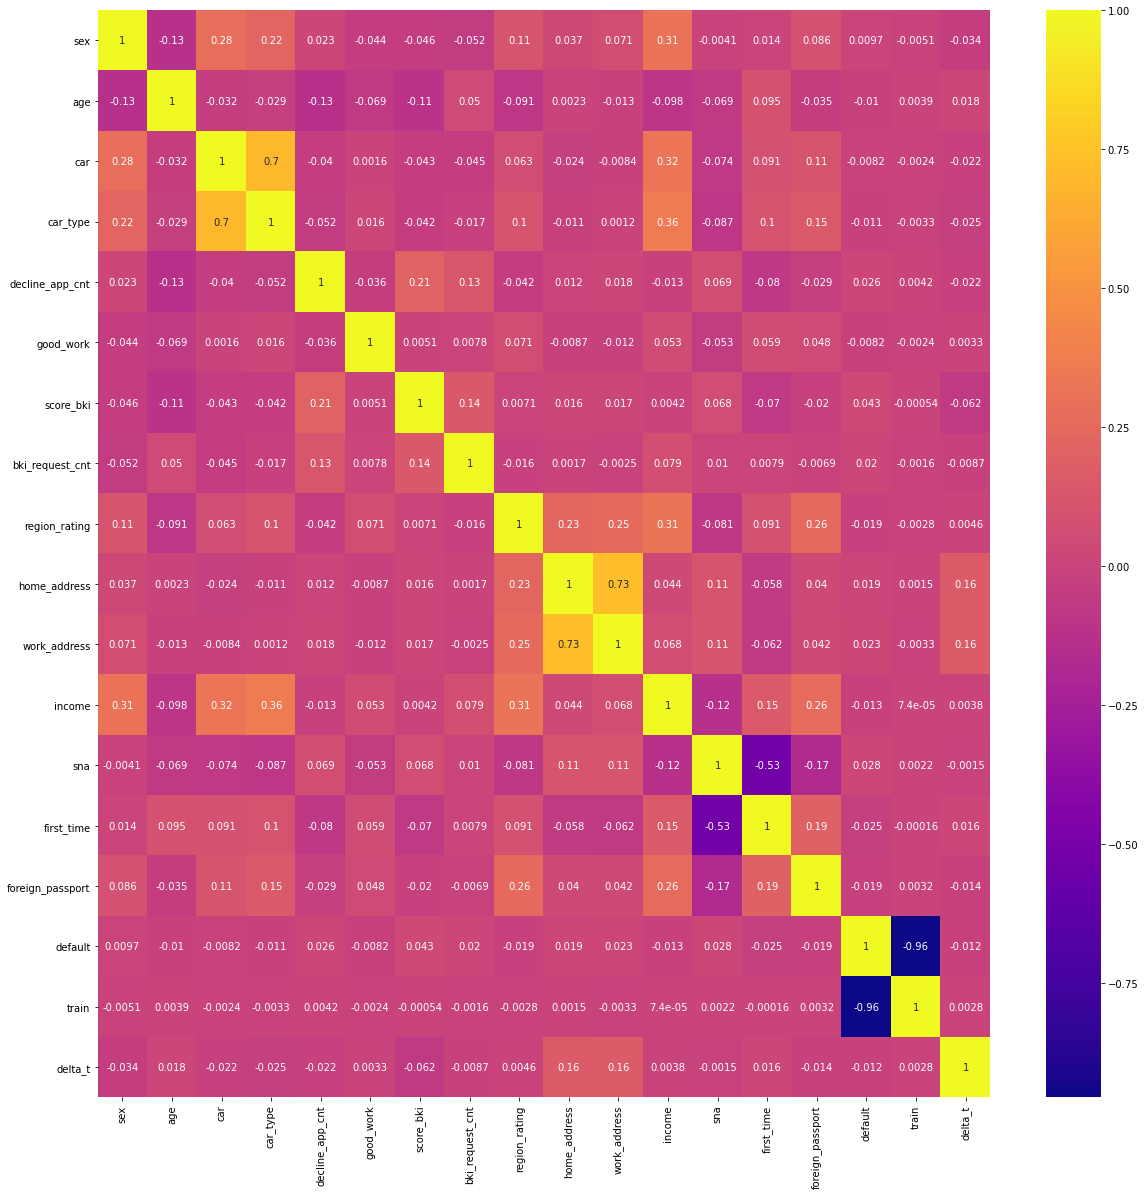

In [24]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(banking.corr(),annot = True, cmap = 'plasma')

In [25]:
#plot boxplots for every subject

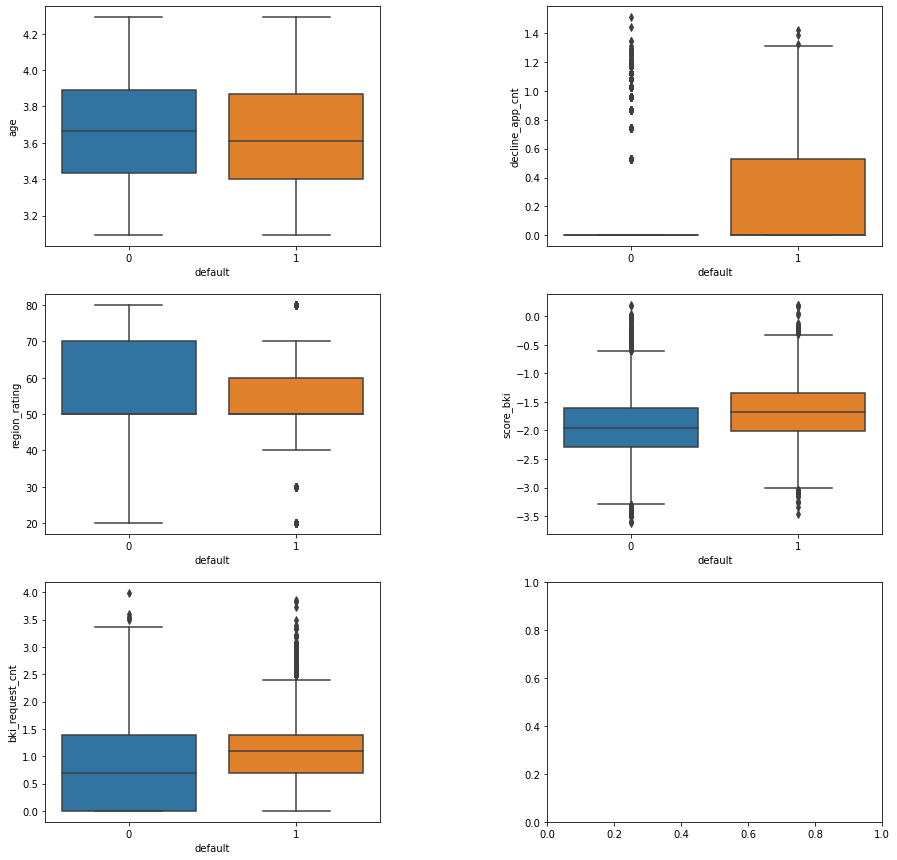

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()
for i in range(len(num_cols)-1):
    sns.boxplot(x="default", y=num_cols[i], data = banking[banking['train'] == 1], orient = 'v', ax=axes[i])

In [27]:
scaler = RobustScaler()
X_num_train = scaler.fit_transform(banking[banking.train ==1][num_cols].values)
X_num_test = scaler.fit_transform(banking[banking.train ==0][num_cols].values)

# LogisticRegression

In [29]:
train = banking[banking['train'] == 1]
test = banking[banking['train'] == 0]

X = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
y = train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, shuffle=True)

In [30]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
# Добавим типы регуляризации
penalty = ['l1', 'l2']
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)
# View best hyperparameters
c = best_model.best_estimator_.get_params()['C']
penalty = best_model.best_estimator_.get_params()['penalty']
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


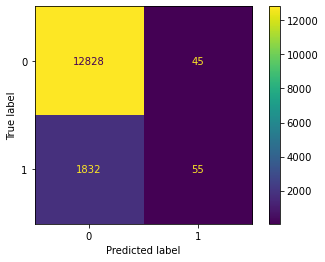

In [31]:
model = LogisticRegression(C=c, penalty=penalty)
model.fit(X_train, y_train)
plot_confusion_matrix(model, X_test, y_test)  
plt.show() 

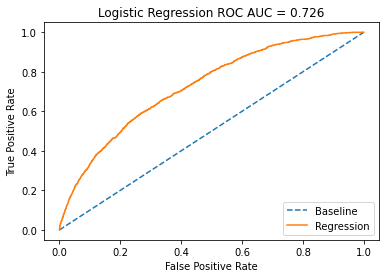

In [32]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [33]:
#Lets try class_weight == 'balanced'

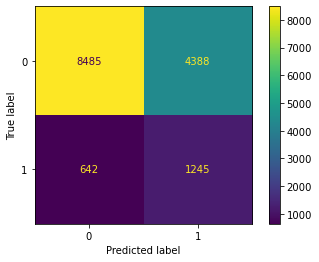

In [34]:
model = LogisticRegression(C=c, penalty=penalty, class_weight = 'balanced')
model.fit(X_train, y_train)
plot_confusion_matrix(model, X_test, y_test)  
plt.show() 

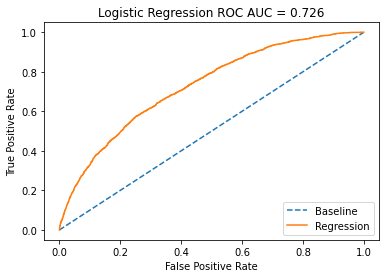

In [35]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

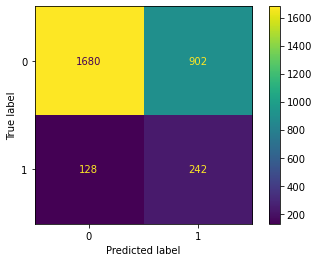

In [36]:
#Check on test part
X_t = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])
y_t = test['default'].values
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_test, y_test, test_size=0.2, random_state=23, shuffle=True)
model = LogisticRegression(C=c, penalty=penalty, class_weight = 'balanced')
model.fit(X_t_train, y_t_train)
plot_confusion_matrix(model, X_t_test, y_t_test)  
plt.show() 

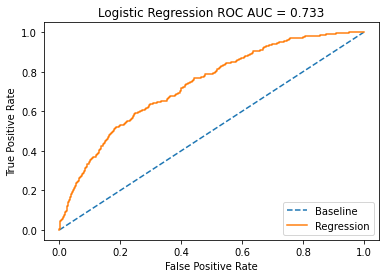

In [37]:
probs_t = model.predict_proba(X_t_test)
probs_t = probs_t[:,1]


fpr, tpr, threshold = roc_curve(y_t_test, probs_t)
roc_auc = roc_auc_score(y_t_test, probs_t)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Publishing 

In [38]:
train = banking[banking['train'] == 1]
test = banking[banking['train'] == 0]

X = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
y = train['default'].values

In [39]:
model = LogisticRegression(C=c, penalty=penalty, class_weight = 'balanced')
model.fit(X, y)

LogisticRegression(C=2.7825594022071245, class_weight='balanced')

In [40]:
x_test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])

In [49]:
y_pred = model.predict_proba(x_test)

In [50]:
y_pred

array([[0.77617812, 0.22382188],
       [0.23411882, 0.76588118],
       [0.66285089, 0.33714911],
       ...,
       [0.18525547, 0.81474453],
       [0.40673138, 0.59326862],
       [0.26682667, 0.73317333]])

In [43]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [51]:
results_df = pd.DataFrame(data = {'client_id':test['client_id'], 'default':y_pred[:,1]})

In [52]:
results_df.to_csv('D_submission.csv', index=False)

In [53]:
results_df

client_id   default
0          74835  0.223822
1          17527  0.765881
2          75683  0.337149
3          26883  0.393156
4          28862  0.128246
...          ...       ...
36344      83775  0.799719
36345     106254  0.122540
36346      81852  0.814745
36347       1971  0.593269
36348      69044  0.733173

[36349 rows x 2 columns]